# Data Challenge: Understanding Customer Spending Behavior

Background:

Banks keep a record of our credit card transaction history and use it to personalize customer engagement and marketing. However, personalizing the approach to all customers may prove expensive and counterproductive. Understanding customer spending behavior allows the bank to focus on either active or inactive card users, anticipate bank revenues, and offer other products and/or services to customers. 

Data Science Challenge:

- How can we personalize our marketing strategies given a record of customer spending?
- How do we predict future spending trend of customers?


### Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn import set_config
import sklearn
set_config(display='diagram')
sns.set_style("whitegrid")
sns.set_context("poster")
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from ydata_profiling import ProfileReport
from sklearn.metrics import make_scorer, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, date
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dropout, Flatten
from skforecast.ForecasterAutoreg import ForecasterAutoreg

### Functions

Convert date of birth to age

In [3]:
def age(born):
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))

Format for the pie chart's autopct

In [4]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.2f}%'.format(pct, v=val)
        return my_format


Custom pie chart plotter

In [5]:
def pie_plotter(data, colors, title, explode=None, wedgecolor = 'maroon', textcolor='black'):
    # plot the given data into a pie chart
    fig, ax = plt.subplots(figsize =(16, 7))
    wedges, texts, autotexts = ax.pie(data, autopct = autopct_format(data), startangle = 90,
                                    wedgeprops={ 'linewidth' : 1, 'edgecolor' : wedgecolor },
                                    colors=colors,
                                    textprops=dict(color=textcolor),
                                    explode=explode)
    ax.legend(wedges,['{0} - {1:.0f}'.format(i,j) for i,j in zip(data.index, data.values)],
            loc ="center left",
            bbox_to_anchor =(1, 0, 0.5, 1))
    
    plt.setp(autotexts, size = 12, weight="bold")
    ax.set_title(title)
    plt.tight_layout()

    plt.show()

Custom bar graph plotter

In [6]:
def bar_plotter(s, palette_color, title, mode=0):
    sns.set(font_scale = 1)
    if mode == 0:
        s.index = [i.replace("HOM_","").replace("_"," ").title() for i in s.index]
        plt.xlabel('Expenditure', fontsize=16)
    else:
        s.index = [i.replace("HOM_","").replace("_"," ").replace(" freq","").title() for i in s.index]
        plt.xlabel('Count', fontsize=16)
    sns.barplot(y = s.index, x=s.values,palette=palette_color)
    
    plt.ylabel('Categories', fontsize=16)
    plt.title(title, fontsize=16)
    plt.show()
    plt.clf

### Load and Explore the Data

In [9]:
# Putting the Data into a Data Frame
df = pd.read_csv('Data.csv')
df.head()

,cc_num,year,month,HOM_tag,HOM_total,HOM_entertainment,HOM_entertainment_freq,HOM_food_dining,HOM_food_dining_freq,HOM_gas_transport,...,HOM_shopping_net,HOM_shopping_net_freq,HOM_shopping_pos,HOM_shopping_pos_freq,HOM_travel,HOM_travel_freq,next_HOM_total,dob,gender,job
0,2703186189652095,2019,1,1,2904.31,218.73,4,90.69,3,67.67,...,557.81,5,140.54,7,12.16,2,5513.39,1988-03-09,F,"Psychologist, counselling"
1,2703186189652095,2019,1,2,5513.39,476.50,7,152.08,2,0.00,...,1941.28,6,620.88,5,22.97,3,3696.99,1988-03-09,F,"Psychologist, counselling"
2,2703186189652095,2019,2,1,3696.99,244.19,2,22.93,1,0.00,...,1422.89,2,176.81,7,0.00,0,2847.65,1988-03-09,F,"Psychologist, counselling"
3,2703186189652095,2019,2,2,2847.65,85.84,2,317.45,6,0.00,...,216.05,3,758.24,4,0.00,0,4785.08,1988-03-09,F,"Psychologist, counselling"
4,2703186189652095,2019,3,1,4785.08,245.70,3,51.88,2,152.95,...,584.38,1,297.77,9,0.00,0,4127.63,1988-03-09,F,"Psychologist, counselling"


#### Integrity of the Dataset

In [10]:
# Inspect the Shape, Check for Nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42676 entries, 0 to 42675
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cc_num                   42676 non-null  int64  
 1   year                     42676 non-null  int64  
 2   month                    42676 non-null  int64  
 3   HOM_tag                  42676 non-null  int64  
 4   HOM_total                42676 non-null  float64
 5   HOM_entertainment        42676 non-null  float64
 6   HOM_entertainment_freq   42676 non-null  int64  
 7   HOM_food_dining          42676 non-null  float64
 8   HOM_food_dining_freq     42676 non-null  int64  
 9   HOM_gas_transport        42676 non-null  float64
 10  HOM_gas_transport_freq   42676 non-null  int64  
 11  HOM_grocery_net          42676 non-null  float64
 12  HOM_grocery_net_freq     42676 non-null  int64  
 13  HOM_grocery_pos          42676 non-null  float64
 14  HOM_grocery_pos_freq  

Shape: (42676,37)

Data types: float64(16), int64(18), object(3)

Missing Data: None

In [11]:
# Check for duplicates
df.duplicated().value_counts()

False    42676
dtype: int64

Duplicate Entries: None

#### Column Transformations

In [12]:
# Convert date of birth to age
df['age'] = df['dob'].apply(age)
df.drop(['dob'],axis=1,inplace=True)

In [13]:
# Convert HOM_tag, year, month to date
df.HOM_tag = [16 if i==2 else i for i in df.HOM_tag]
df['date'] = pd.to_datetime(df.year.astype(str) + '/' + df.month.astype(str) + '/' + df.HOM_tag.astype(str))
df.drop(['month', 'year', 'HOM_tag'],axis=1,inplace=True)

#### Summary Stats

In [14]:
df.describe(include='all')

,cc_num,HOM_total,HOM_entertainment,HOM_entertainment_freq,HOM_food_dining,HOM_food_dining_freq,HOM_gas_transport,HOM_gas_transport_freq,HOM_grocery_net,HOM_grocery_net_freq,...,HOM_shopping_net_freq,HOM_shopping_pos,HOM_shopping_pos_freq,HOM_travel,HOM_travel_freq,next_HOM_total,gender,job,age,date
count,4.267600e+04,42676.000000,42676.000000,42676.000000,42676.000000,42676.000000,42676.000000,42676.000000,42676.000000,42676.000000,...,42676.000000,42676.000000,42676.000000,42676.000000,42676.000000,42676.000000,42676,42676,42676.000000,42676
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,475,NaN,47
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,F,Naval architect,NaN,2019-01-01 00:00:00
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21620,282,NaN,908
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-01 00:00:00
mean,4.090328e+17,2809.572456,190.613635,3.017317,149.941091,2.945965,268.919216,4.222233,78.420014,1.457236,...,3.092230,275.572899,3.726638,144.849358,1.304621,2879.603475,NaN,NaN,51.626652,NaN
std,1.293285e+18,2152.725961,213.399802,2.533202,154.668309,2.546023,240.319483,3.889819,106.691098,1.932577,...,2.780091,521.247543,3.181651,722.193572,1.369925,2226.584890,NaN,NaN,17.983452,NaN
min,6.041621e+10,10.560000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,10.560000,NaN,NaN,18.000000,NaN
25%,1.800391e+14,1275.165000,34.210000,1.000000,30.207500,1.000000,81.880000,1.000000,0.000000,0.000000,...,1.000000,10.070000,1.000000,0.000000,0.000000,1300.782500,NaN,NaN,37.000000,NaN


#### Exhaustive Profiling

In [15]:
profile = ProfileReport(df, title="Pandas Profiling Report", minimal=True)
profile.to_file("data-profiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Insights from the Profile:
- Credit Card Number: 908 distinct values
- Job: 475 distinct values
- Age: 80 distinct values (18-98 years old)
- Date: 47 distinct values (First Half of January 2019 to First Half of December 2020)

#### Some EDA visualizations

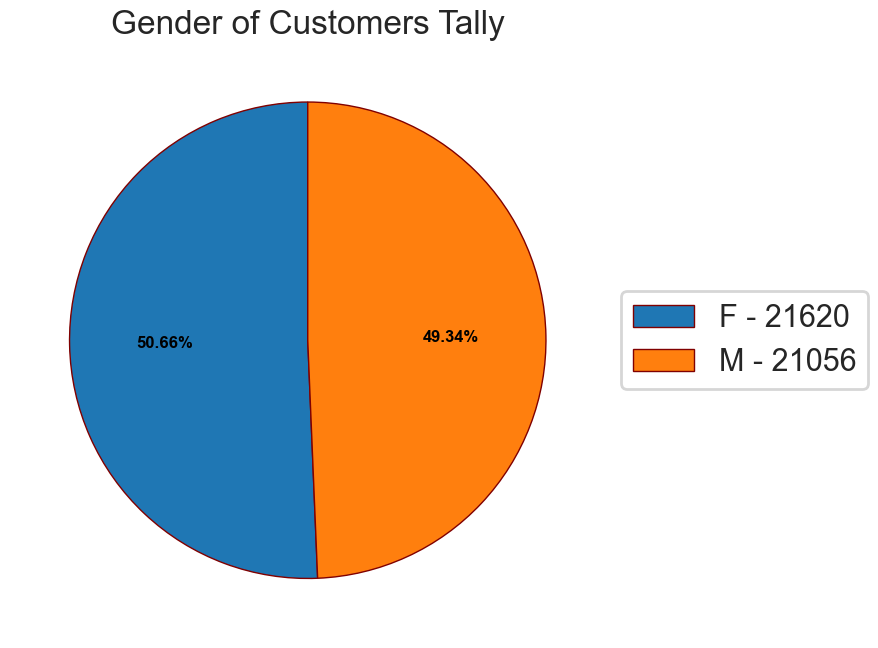

In [17]:
title = "Gender of Customers Tally"
pie_plotter(df['gender'].value_counts(),None,title)

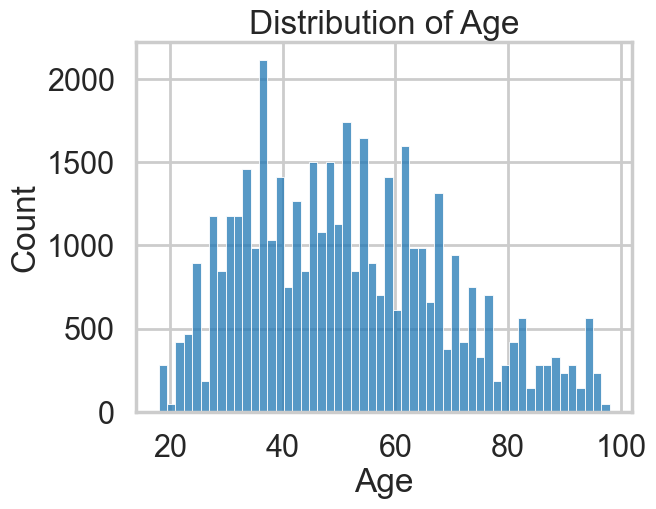

In [20]:
sns.histplot(df['age'])
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.show()

### Forecasting Customer's Spending Trend

In [15]:
# Aggregate the data to all distinct dates
df1 = df.groupby(df['date'].dt.date).mean()

In [16]:
df1

,cc_num,HOM_total,HOM_entertainment,HOM_entertainment_freq,HOM_food_dining,HOM_food_dining_freq,HOM_gas_transport,HOM_gas_transport_freq,HOM_grocery_net,HOM_grocery_net_freq,...,HOM_personal_care,HOM_personal_care_freq,HOM_shopping_net,HOM_shopping_net_freq,HOM_shopping_pos,HOM_shopping_pos_freq,HOM_travel,HOM_travel_freq,next_HOM_total,age
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,4.090328e+17,1953.701322,137.204780,2.114537,107.234736,2.129956,183.879053,2.868943,56.110914,1.011013,...,99.895771,2.078194,164.934537,2.153084,192.035286,2.581498,97.874868,0.879956,1898.688161,51.622247
2019-01-16,4.090328e+17,1898.688161,132.748205,2.044053,102.141002,1.977974,184.123139,2.879956,51.772952,0.955947,...,95.933921,2.029736,156.386850,2.153084,177.037412,2.507709,91.709152,0.882159,1884.813348,51.622247
2019-02-01,4.090328e+17,1884.813348,133.458634,2.083700,101.146145,2.008811,180.390396,2.809471,53.106817,0.970264,...,96.416982,1.948238,162.655980,2.109031,172.110220,2.533040,92.154042,0.871145,1783.260606,51.622247
2019-02-16,4.090328e+17,1783.260606,118.698282,1.868943,97.928932,1.900881,178.130044,2.812775,50.279890,0.946035,...,93.431366,1.878855,138.278447,1.898678,170.385187,2.417401,72.564813,0.864537,2503.993480,51.622247
2019-03-01,4.090328e+17,2503.993480,157.420903,2.635463,130.718326,2.623348,233.647676,3.657489,69.288590,1.267621,...,116.228293,2.453744,195.583700,2.837004,246.708943,3.251101,164.387775,1.247797,2771.610936,51.622247
2019-03-16,4.090328e+17,2771.610936,184.486531,2.947137,149.492004,2.859031,259.246542,4.069383,75.220947,1.421806,...,132.419659,2.866740,206.355011,3.137665,260.003546,3.769824,202.035441,1.287445,2524.501685,51.622247
2019-04-01,4.090328e+17,2524.501685,179.266828,2.833700,137.574890,2.658590,255.011432,4.008811,75.047808,1.401982,...,129.635485,2.693833,177.930330,2.765419,235.509857,3.375551,121.413337,1.079295,2496.905022,51.622247
2019-04-16,4.090328e+17,2496.905022,171.578161,2.633260,136.769956,2.682819,234.170782,3.664097,69.686993,1.280837,...,125.954559,2.531938,196.115198,2.698238,220.000782,3.301762,176.161366,1.122247,2463.186795,51.622247
2019-05-01,4.090328e+17,2463.186795,161.068822,2.601322,131.008315,2.601322,236.323965,3.693833,72.137081,1.325991,...,126.326333,2.557269,210.643634,2.756608,258.277643,3.265419,113.573943,1.169604,2878.612996,51.622247


In [17]:
df1.describe(include='all')

,cc_num,HOM_total,HOM_entertainment,HOM_entertainment_freq,HOM_food_dining,HOM_food_dining_freq,HOM_gas_transport,HOM_gas_transport_freq,HOM_grocery_net,HOM_grocery_net_freq,...,HOM_personal_care,HOM_personal_care_freq,HOM_shopping_net,HOM_shopping_net_freq,HOM_shopping_pos,HOM_shopping_pos_freq,HOM_travel,HOM_travel_freq,next_HOM_total,age
count,4.700000e+01,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,4.700000e+01
mean,4.090328e+17,2809.572456,190.613635,3.017317,149.941091,2.945965,268.919216,4.222233,78.420014,1.457236,...,140.624773,2.923610,223.285213,3.092230,275.572899,3.726638,144.849358,1.304621,2879.603475,5.162225e+01
std,1.293838e+02,791.818711,53.770529,0.848741,40.704787,0.799063,76.207501,1.200828,22.098985,0.408401,...,38.742900,0.816870,66.031814,0.875678,83.784977,1.043928,48.989252,0.370722,857.321403,4.309347e-14
min,4.090328e+17,1613.841916,108.227952,1.705947,83.412621,1.646476,154.877786,2.425110,49.351079,0.925110,...,80.434460,1.676211,121.476916,1.751101,157.420870,2.210352,72.564813,0.744493,1613.841916,5.162225e+01
25%,4.090328e+17,2474.801608,161.930710,2.632709,130.863320,2.612335,233.909229,3.669053,68.157946,1.267070,...,121.534862,2.536894,185.211311,2.699890,235.720341,3.275881,112.526575,1.147577,2482.211597,5.162225e+01
50%,4.090328e+17,2641.978238,179.859020,2.818282,143.601200,2.786344,252.253932,3.957048,75.047808,1.401982,...,133.294857,2.752203,211.191046,2.888767,267.041740,3.508811,144.546520,1.247797,2669.663040,5.162225e+01
75%,4.090328e+17,3157.391217,214.196845,3.389868,168.335303,3.311674,306.737384,4.819383,86.583904,1.610683,...,159.264124,3.300661,249.063563,3.449339,293.320870,4.183921,164.620121,1.452643,3206.428855,5.162225e+01
max,4.090328e+17,5305.750231,362.913634,5.748899,282.793414,5.511013,510.624075,8.040749,149.884615,2.792952,...,259.690815,5.494493,439.439361,5.881057,553.804559,7.024229,308.155815,2.495595,5305.750231,5.162225e+01


#### Preprocessing

In [18]:
# Dropping age and cc_num
df2 = df1.drop(columns=['cc_num', 'age']).astype(float)
df2

,HOM_total,HOM_entertainment,HOM_entertainment_freq,HOM_food_dining,HOM_food_dining_freq,HOM_gas_transport,HOM_gas_transport_freq,HOM_grocery_net,HOM_grocery_net_freq,HOM_grocery_pos,...,HOM_misc_pos_freq,HOM_personal_care,HOM_personal_care_freq,HOM_shopping_net,HOM_shopping_net_freq,HOM_shopping_pos,HOM_shopping_pos_freq,HOM_travel,HOM_travel_freq,next_HOM_total
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1953.701322,137.204780,2.114537,107.234736,2.129956,183.879053,2.868943,56.110914,1.011013,298.850606,...,1.704846,99.895771,2.078194,164.934537,2.153084,192.035286,2.581498,97.874868,0.879956,1898.688161
2019-01-16,1898.688161,132.748205,2.044053,102.141002,1.977974,184.123139,2.879956,51.772952,0.955947,303.613700,...,1.756608,95.933921,2.029736,156.386850,2.153084,177.037412,2.507709,91.709152,0.882159,1884.813348
2019-02-01,1884.813348,133.458634,2.083700,101.146145,2.008811,180.390396,2.809471,53.106817,0.970264,293.157709,...,1.679515,96.416982,1.948238,162.655980,2.109031,172.110220,2.533040,92.154042,0.871145,1783.260606
2019-02-16,1783.260606,118.698282,1.868943,97.928932,1.900881,178.130044,2.812775,50.279890,0.946035,295.193579,...,1.671806,93.431366,1.878855,138.278447,1.898678,170.385187,2.417401,72.564813,0.864537,2503.993480
2019-03-01,2503.993480,157.420903,2.635463,130.718326,2.623348,233.647676,3.657489,69.288590,1.267621,392.764570,...,2.268722,116.228293,2.453744,195.583700,2.837004,246.708943,3.251101,164.387775,1.247797,2771.610936
2019-03-16,2771.610936,184.486531,2.947137,149.492004,2.859031,259.246542,4.069383,75.220947,1.421806,451.001388,...,2.477974,132.419659,2.866740,206.355011,3.137665,260.003546,3.769824,202.035441,1.287445,2524.501685
2019-04-01,2524.501685,179.266828,2.833700,137.574890,2.658590,255.011432,4.008811,75.047808,1.401982,408.873524,...,2.334802,129.635485,2.693833,177.930330,2.765419,235.509857,3.375551,121.413337,1.079295,2496.905022
2019-04-16,2496.905022,171.578161,2.633260,136.769956,2.682819,234.170782,3.664097,69.686993,1.280837,395.855374,...,2.222467,125.954559,2.531938,196.115198,2.698238,220.000782,3.301762,176.161366,1.122247,2463.186795
2019-05-01,2463.186795,161.068822,2.601322,131.008315,2.601322,236.323965,3.693833,72.137081,1.325991,401.715716,...,2.201542,126.326333,2.557269,210.643634,2.756608,258.277643,3.265419,113.573943,1.169604,2878.612996


Train dates : 2019-01-01 --- 2020-07-16  (n=38)
Test dates  : 2020-08-01 --- 2020-12-01  (n=9)


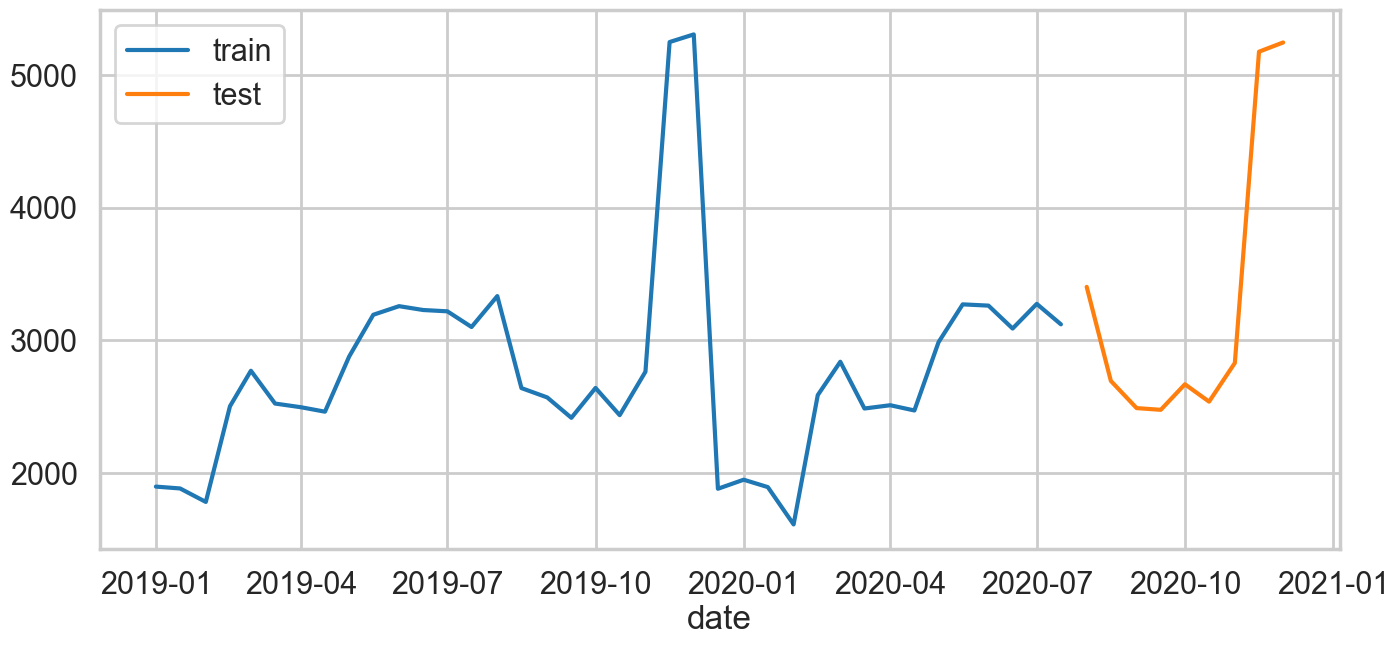

In [19]:
# Split data into train-test
steps = 38
df_train = df2[:steps]
df_test  = df2[steps:]

print(f"Train dates : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Test dates  : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

fig, ax = plt.subplots(figsize=(16, 7))
df_train['next_HOM_total'].plot(ax=ax, label='train')
df_test['next_HOM_total'].plot(ax=ax, label='test')
ax.legend();

We're trying to predict the orange line plot

In [20]:
# Scaling the data
scaler = StandardScaler()
scaler.fit(df_train)
df_train_scaled = np.array(scaler.transform(df_train))

In [21]:
# Setting x and y train
trainX = []
trainY = []
trainY = df_train_scaled[:,-1].reshape(-1,1)
trainX = df_train_scaled.reshape(-1, 30,1)

#### Random Forest Regressor: A Univariate Analysis

Autoregression using 20 lags with Random Forest Regressor with 5 maximum depth and 500 estimators

In [22]:
# Building the model
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=5,n_estimators=500),
                lags      = 20
             )

forecaster.fit(y=df_train['next_HOM_total'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=5, n_estimators=500) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 37] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-05-24 13:04:50 
Last fit date: 2023-05-24 13:04:51 
Skforecast version: 0.8.0 
Python version: 3.10.9 
Forecaster id: None 

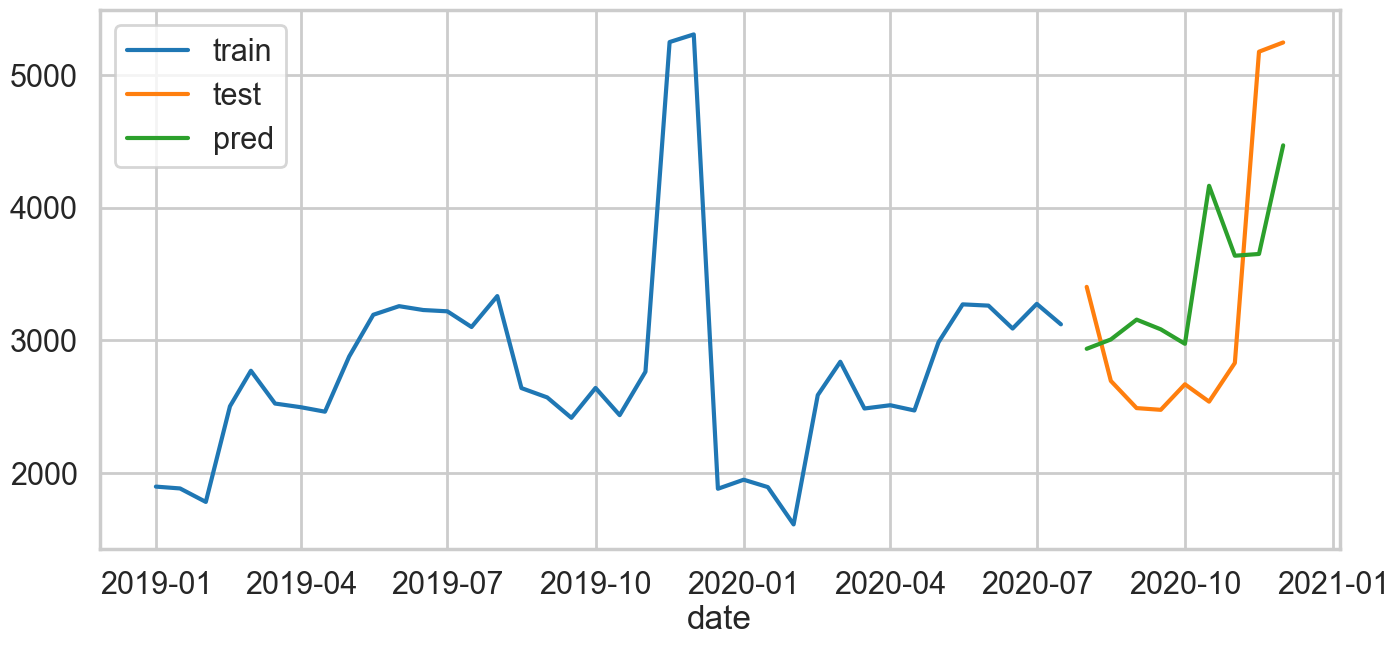

In [23]:
# Plotting the predicted trend
forecast = pd.DataFrame(forecaster.predict(steps=9))
forecast = forecast.set_index(df_test.index)
fig, ax = plt.subplots(figsize=(16, 7))
df_train['next_HOM_total'].plot(ax=ax, label='train')
df_test['next_HOM_total'].plot(ax=ax, label='test')
forecast.plot(ax=ax, label='predictions')
ax.legend();

In [24]:
# Evaluation
print("MSE: ", mean_squared_error(df_test['next_HOM_total'],forecast))
print("MAPE: ", mean_absolute_percentage_error(df_test['next_HOM_total'],forecast))
print("R2 Score: ", r2_score(df_test['next_HOM_total'],forecast))

MSE:  826877.690449822
MAPE:  0.2497723638965486
R2 Score:  0.27070852038119675


The univariate model is performing poorly based on the metrics score above

### LSTM: A Multivariate Analysis

In [25]:
# Building the LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=True)))
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [41]:
# Training the Model
history = model.fit(trainX, trainY, epochs=200, batch_size=1,verbose=1)

Epoch 1/200
38/38 [==============================] - 1s 25ms/step - loss: 0.0685
Epoch 2/200
38/38 [==============================] - 1s 23ms/step - loss: 0.0454
Epoch 3/200
38/38 [==============================] - 1s 20ms/step - loss: 0.0616
Epoch 4/200
38/38 [==============================] - 1s 20ms/step - loss: 0.0303
Epoch 5/200
38/38 [==============================] - 1s 20ms/step - loss: 0.0245
Epoch 6/200
38/38 [==============================] - 1s 20ms/step - loss: 0.0078
Epoch 7/200
38/38 [==============================] - 1s 20ms/step - loss: 0.0144
Epoch 8/200
38/38 [==============================] - 1s 20ms/step - loss: 0.0187
Epoch 9/200
38/38 [==============================] - 1s 20ms/step - loss: 0.0217
Epoch 10/200
38/38 [==============================] - 1s 20ms/step - loss: 0.0361
Epoch 11/200
38/38 [==============================] - 1s 20ms/step - loss: 0.0254
Epoch 12/200
38/38 [==============================] - 1s 19ms/step - loss: 0.0068
Epoch 13/200
38/38 [=====

38/38 [==============================] - 0s 13ms/step - loss: 0.0099
Epoch 102/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0088
Epoch 103/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0211
Epoch 104/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0305
Epoch 105/200
38/38 [==============================] - 0s 13ms/step - loss: 0.0148
Epoch 106/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0135
Epoch 107/200
38/38 [==============================] - 0s 13ms/step - loss: 0.0240
Epoch 108/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0195
Epoch 109/200
38/38 [==============================] - 1s 14ms/step - loss: 0.0078
Epoch 110/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0157
Epoch 111/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0127
Epoch 112/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0064
Epoch 113/200
38/3

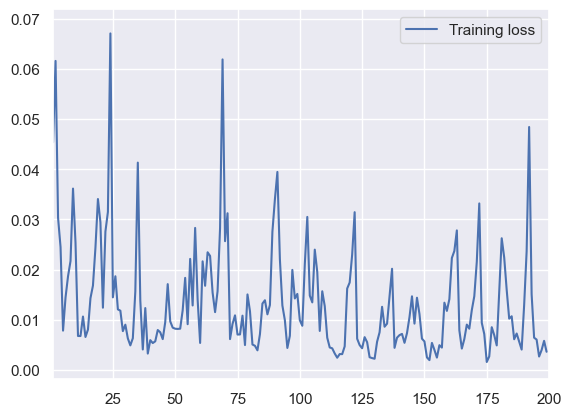

In [42]:
# Plotting the Training Loss across all Epochs
plt.plot(history.history['loss'], label='Training loss')
plt.xlim([1,200])
plt.legend()

In [43]:
# Summary of the Model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 128)          33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 64)           41216     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 64)                122944    
                                                                 
 dense_1 (Dense)             (None, 8)                 5

In [44]:
# Predicting the test set
df_test_scaled = np.array(scaler.transform(df_test)).reshape(-1, 30,1)
forecast = model.predict(df_test_scaled) 
forecast_copies = np.repeat(forecast, df_test.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
print("MSE: ", mean_squared_error(df_test['next_HOM_total'],y_pred_future))
print("MAPE: ", mean_absolute_percentage_error(df_test['next_HOM_total'],y_pred_future))
print("R2 Score: ", r2_score(df_test['next_HOM_total'],y_pred_future))

1/1 [==============================] - 0s 32ms/step
MSE:  7991.889871218225
MAPE:  0.02100664967270039
R2 Score:  0.9929512946637119


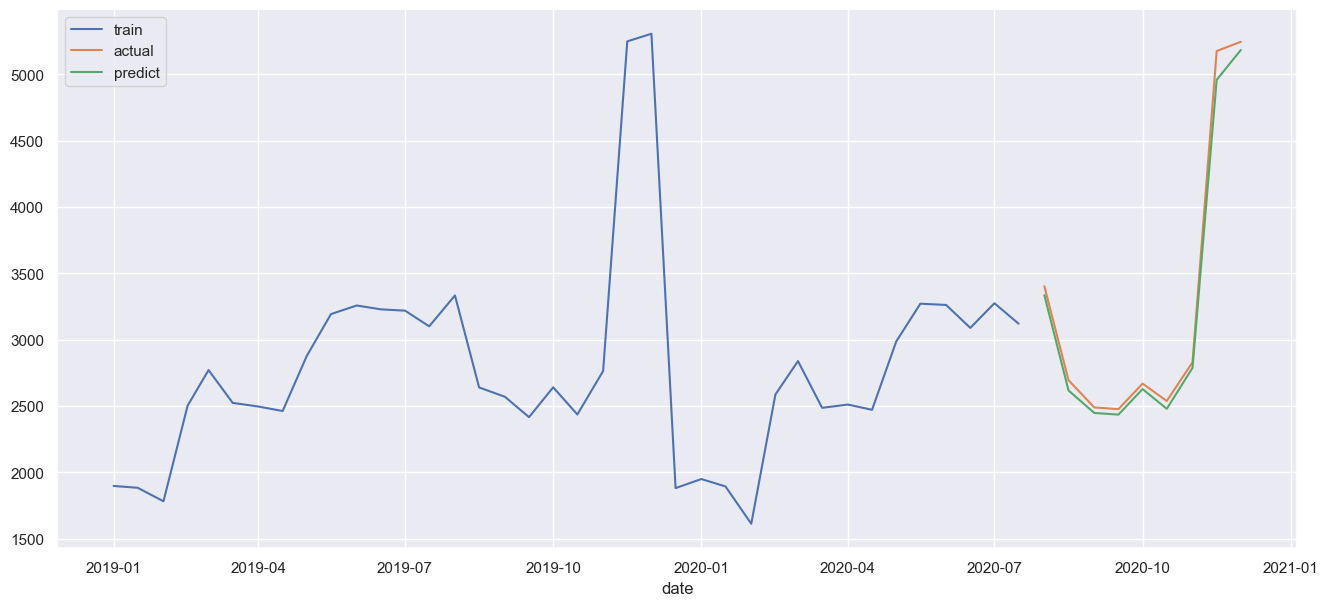

In [46]:
fig, ax = plt.subplots(figsize=(16, 7))
df_train['next_HOM_total'].plot(ax=ax, label='train')
df_test['next_HOM_total'].plot(ax=ax, label='actual')
df_forecast.plot(ax=ax, label='predict')
ax.legend();

From the score of the regression metrics, as well as the resulting plot, it can be observed that the LSTM model is performing excellently in predicting the future trend of customer's spending behavior.

In [32]:
# Not implemented, the latest shap.DeepExplainer is not compatible with the latest tensorflow
# import shap
# tf.compat.v1.disable_v2_behavior()
# explainer = shap.DeepExplainer(model, trainX)
# shap_values = explainer.shap_values(df_test_scaled)
# shap.summary_plot(shap_values,trainX, plot_type="bar", matplotlib=True)
# plt.show()

### Personalized Marketing Strategy

In [30]:
# Putting the Data into a Data Frame
df = pd.read_csv('Data.csv')
df.head()

,cc_num,year,month,HOM_tag,HOM_total,HOM_entertainment,HOM_entertainment_freq,HOM_food_dining,HOM_food_dining_freq,HOM_gas_transport,...,HOM_shopping_net,HOM_shopping_net_freq,HOM_shopping_pos,HOM_shopping_pos_freq,HOM_travel,HOM_travel_freq,next_HOM_total,dob,gender,job
0,2703186189652095,2019,1,1,2904.31,218.73,4,90.69,3,67.67,...,557.81,5,140.54,7,12.16,2,5513.39,1988-03-09,F,"Psychologist, counselling"
1,2703186189652095,2019,1,2,5513.39,476.50,7,152.08,2,0.00,...,1941.28,6,620.88,5,22.97,3,3696.99,1988-03-09,F,"Psychologist, counselling"
2,2703186189652095,2019,2,1,3696.99,244.19,2,22.93,1,0.00,...,1422.89,2,176.81,7,0.00,0,2847.65,1988-03-09,F,"Psychologist, counselling"
3,2703186189652095,2019,2,2,2847.65,85.84,2,317.45,6,0.00,...,216.05,3,758.24,4,0.00,0,4785.08,1988-03-09,F,"Psychologist, counselling"
4,2703186189652095,2019,3,1,4785.08,245.70,3,51.88,2,152.95,...,584.38,1,297.77,9,0.00,0,4127.63,1988-03-09,F,"Psychologist, counselling"


In [31]:
# Trimming the data, adding the values of _pos and _net variables
df1 = df.copy()
df1["HOM_grocery"] = df1["HOM_grocery_net"] + df1["HOM_grocery_pos"]
df1["HOM_grocery_freq"] = df1["HOM_grocery_net_freq"] + df1["HOM_grocery_pos_freq"]
df1["HOM_misc"] = df1["HOM_misc_net"] + df1["HOM_misc_pos"]
df1["HOM_misc_freq"] = df1["HOM_misc_net_freq"] + df1["HOM_misc_pos_freq"]
df1["HOM_shopping"] = df1["HOM_shopping_net"] + df1["HOM_shopping_pos"]
df1["HOM_shopping_freq"] = df1["HOM_shopping_net_freq"] + df1["HOM_shopping_pos_freq"]
df1.drop(["HOM_tag", "HOM_total", "next_HOM_total", "dob", "gender","job","HOM_grocery_net","HOM_grocery_pos",
         "HOM_grocery_net_freq","HOM_grocery_pos_freq","HOM_misc_net","HOM_misc_pos","HOM_misc_net_freq",
         "HOM_misc_pos_freq","HOM_shopping_net","HOM_shopping_pos","HOM_shopping_net_freq","HOM_shopping_pos_freq",],
         axis=1,inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42676 entries, 0 to 42675
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cc_num                   42676 non-null  int64  
 1   year                     42676 non-null  int64  
 2   month                    42676 non-null  int64  
 3   HOM_entertainment        42676 non-null  float64
 4   HOM_entertainment_freq   42676 non-null  int64  
 5   HOM_food_dining          42676 non-null  float64
 6   HOM_food_dining_freq     42676 non-null  int64  
 7   HOM_gas_transport        42676 non-null  float64
 8   HOM_gas_transport_freq   42676 non-null  int64  
 9   HOM_health_fitness       42676 non-null  float64
 10  HOM_health_fitness_freq  42676 non-null  int64  
 11  HOM_home                 42676 non-null  float64
 12  HOM_home_freq            42676 non-null  int64  
 13  HOM_kids_pets            42676 non-null  float64
 14  HOM_kids_pets_freq    

#### Personalized Visualization of Customer's Spending Behavior

In [32]:
def marketing_eda(df, cc_num, mode="total", month=None, last=None):
    if mode == "total":
        df2 = df.groupby(["cc_num"]).sum()
        s = df2[df2.index == cc_num]
        s = s.iloc[0,[2,4,6,8,10,12,14,16,18,20,22]]
        palette_color = sns.color_palette('husl', 11)
        title = f"Total Expenditure per Category ({cc_num})"
        bar_plotter(s,palette_color,title)
        print(f"Recommendation: {s.idxmax(axis=0)}")
        s1 = df2[df2.index == cc_num]
        s1 = s1.iloc[0,[3,5,7,9,11,13,15,17,19,21,23]]
        s1.index = s.index
        title = f"Total Frequency per Category ({cc_num})"
        bar_plotter(s1,palette_color,title,1)
        print(f"Recommendation: {s1.idxmax(axis=0)}")
    elif mode == "month":
        month_list = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
        df2 = df.groupby(["cc_num","month"]).sum()
        s = df2[df2.index == (cc_num, month_list.index(month)+1)]
        s = s.iloc[0,[1,3,5,7,9,11,13,15,17,19,21]]
        palette_color = sns.color_palette('husl', 11)
        title = f"Total Expenditure per Category for {month} ({cc_num})"
        bar_plotter(s,palette_color,title)
        print(f"Recommendation: {s.idxmax(axis=0)}")
        s1 = df2[df2.index == (cc_num, month_list.index(month)+1)]
        s1 = s1.iloc[0,[2,4,6,8,10,12,14,16,18,20,22]]
        s1.index = s.index
        title = f"Total Frequency per Category for {month} ({cc_num})"
        bar_plotter(s1,palette_color,title,1)
        print(f"Recommendation: {s1.idxmax(axis=0)}")
    elif mode == "last":
        df1 = df.copy()
        df1['date'] = pd.to_datetime(df1.year.astype(str) + '/' + df1.month.astype(str) + '/' + '1')
        df1.drop(['month', 'year'],axis=1,inplace=True)
        df2 = df1.groupby(["cc_num","date"]).sum()
        s = df2.loc[cc_num,:].iloc[-last:].aggregate(['sum'])
        s = s.iloc[0,[0,2,4,6,8,10,12,14,16,18,20]]
        palette_color = sns.color_palette('husl', 11)
        title = f"Total Expenditure per Category for the Last {last} Months ({cc_num})"
        bar_plotter(s,palette_color,title)
        print(f"Recommendation: {s.idxmax(axis=0)}")
        s1 = df2.loc[cc_num,:].iloc[-last:].aggregate(['sum'])
        s1 = s1.iloc[0,[1,3,5,7,9,11,13,15,17,19,21]]
        s1.index = s.index
        title = f"Total Frequency per Category for the Last {last} Months ({cc_num})"
        bar_plotter(s1,palette_color,title)
        print(f"Recommendation: {s1.idxmax(axis=0)}")
        

Credit Card Number: 2703186189652095
Pick One 
 - total: Include the Whole Transaction History of the Customer
 - month: Only Include the Transaction in the Specified Month
 - last: Only Include the Transaction in Recent Number of Months Specified 
Mode: last
Number of Recent Months: 10


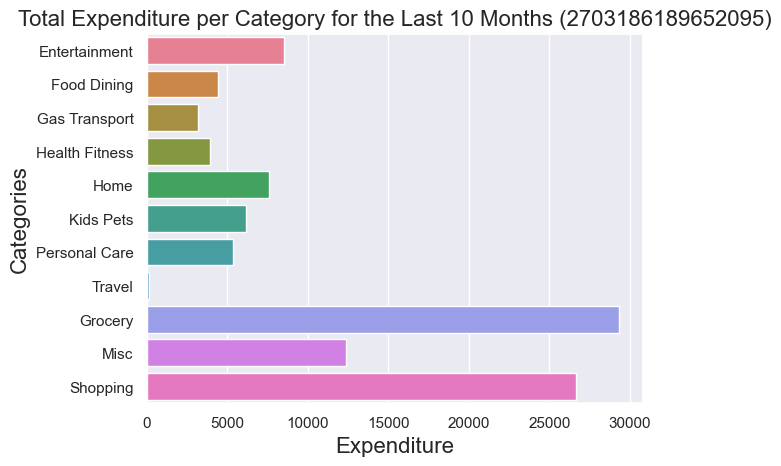

Recommendation: Grocery


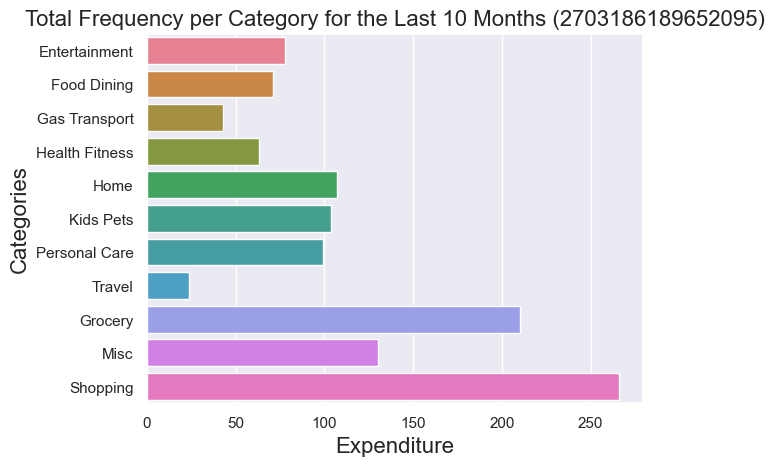

Recommendation: Shopping


In [40]:
cc_num = int(input("Credit Card Number: "))
mode = str(input("Pick One \n - total: Include the Whole Transaction History of the Customer" 
                 "\n - month: Only Include the Transaction in the Specified Month" 
                 "\n - last: Only Include the Transaction in Recent Number of Months Specified \nMode: "))
month = str(input("Month (Capitalize the First Letter): ")) if mode=='month' else None
last = int(input("Number of Recent Months: ")) if mode=='last' else None
marketing_eda(df1, cc_num, mode, month, last)

Note: No input handling yet, please input the correct values.

#### Developing a Scoring Mechanism

In [7]:
# Putting the Data into a Data Frame
df = pd.read_csv('Data.csv')
df.head()

,cc_num,year,month,HOM_tag,HOM_total,HOM_entertainment,HOM_entertainment_freq,HOM_food_dining,HOM_food_dining_freq,HOM_gas_transport,...,HOM_shopping_net,HOM_shopping_net_freq,HOM_shopping_pos,HOM_shopping_pos_freq,HOM_travel,HOM_travel_freq,next_HOM_total,dob,gender,job
0,2703186189652095,2019,1,1,2904.31,218.73,4,90.69,3,67.67,...,557.81,5,140.54,7,12.16,2,5513.39,1988-03-09,F,"Psychologist, counselling"
1,2703186189652095,2019,1,2,5513.39,476.50,7,152.08,2,0.00,...,1941.28,6,620.88,5,22.97,3,3696.99,1988-03-09,F,"Psychologist, counselling"
2,2703186189652095,2019,2,1,3696.99,244.19,2,22.93,1,0.00,...,1422.89,2,176.81,7,0.00,0,2847.65,1988-03-09,F,"Psychologist, counselling"
3,2703186189652095,2019,2,2,2847.65,85.84,2,317.45,6,0.00,...,216.05,3,758.24,4,0.00,0,4785.08,1988-03-09,F,"Psychologist, counselling"
4,2703186189652095,2019,3,1,4785.08,245.70,3,51.88,2,152.95,...,584.38,1,297.77,9,0.00,0,4127.63,1988-03-09,F,"Psychologist, counselling"


In [8]:
df1 = df.copy()
df1["HOM_grocery"] = df1["HOM_grocery_net"] + df1["HOM_grocery_pos"]
df1["HOM_grocery_freq"] = df1["HOM_grocery_net_freq"] + df1["HOM_grocery_pos_freq"]
df1["HOM_misc"] = df1["HOM_misc_net"] + df1["HOM_misc_pos"]
df1["HOM_misc_freq"] = df1["HOM_misc_net_freq"] + df1["HOM_misc_pos_freq"]
df1["HOM_shopping"] = df1["HOM_shopping_net"] + df1["HOM_shopping_pos"]
df1["HOM_shopping_freq"] = df1["HOM_shopping_net_freq"] + df1["HOM_shopping_pos_freq"]
df1.drop(["month", "year", "HOM_tag", "next_HOM_total", "dob", "gender","job","HOM_grocery_net","HOM_grocery_pos",
         "HOM_grocery_net_freq","HOM_grocery_pos_freq","HOM_misc_net","HOM_misc_pos","HOM_misc_net_freq",
         "HOM_misc_pos_freq","HOM_shopping_net","HOM_shopping_pos","HOM_shopping_net_freq","HOM_shopping_pos_freq",],
         axis=1,inplace=True)
df2 = df1.groupby("cc_num").mean()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 908 entries, 60416207185 to 4992346398065154184
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   HOM_total                908 non-null    float64
 1   HOM_entertainment        908 non-null    float64
 2   HOM_entertainment_freq   908 non-null    float64
 3   HOM_food_dining          908 non-null    float64
 4   HOM_food_dining_freq     908 non-null    float64
 5   HOM_gas_transport        908 non-null    float64
 6   HOM_gas_transport_freq   908 non-null    float64
 7   HOM_health_fitness       908 non-null    float64
 8   HOM_health_fitness_freq  908 non-null    float64
 9   HOM_home                 908 non-null    float64
 10  HOM_home_freq            908 non-null    float64
 11  HOM_kids_pets            908 non-null    float64
 12  HOM_kids_pets_freq       908 non-null    float64
 13  HOM_personal_care        908 non-null    float64
 14  

In [63]:
expenditure = df2.iloc[:,[1,3,5,7,9,11,13,15,17,19,21]]
frequency = df2.iloc[:,[2,4,6,8,10,12,14,16,18,20,22]]
expenditure_score = expenditure.apply(lambda x: x.div(x.sum()), axis=1).astype(float)
frequency_score = frequency.apply(lambda x: x.div(x.sum()), axis=1).astype(float)
frequency_score.columns = expenditure_score.columns
combined_score = expenditure_score.combine(frequency_score, lambda x,y: (x+y)/2)
combined_score['Recommendation'] = combined_score.idxmax(axis=1)
combined_score

,HOM_entertainment,HOM_food_dining,HOM_gas_transport,HOM_health_fitness,HOM_home,HOM_kids_pets,HOM_personal_care,HOM_travel,HOM_grocery,HOM_misc,HOM_shopping,Recommendation
cc_num,,,,,,,,,,,,
60416207185,0.054265,0.041340,0.143100,0.051747,0.091705,0.089110,0.075651,0.015793,0.159182,0.091333,0.186776,HOM_shopping
60422928733,0.076640,0.095195,0.105977,0.051601,0.105768,0.103257,0.074559,0.024495,0.143937,0.095216,0.123356,HOM_grocery
60423098130,0.069170,0.047261,0.097070,0.056378,0.072222,0.079635,0.063550,0.232157,0.108274,0.078413,0.095871,HOM_travel
60427851591,0.065117,0.040103,0.045979,0.064658,0.103673,0.067911,0.032674,0.130074,0.170148,0.099217,0.180445,HOM_shopping
60487002085,0.068575,0.066027,0.112336,0.071232,0.116585,0.076980,0.037730,0.050299,0.155863,0.140973,0.103402,HOM_grocery
...,...,...,...,...,...,...,...,...,...,...,...,...
4958589671582726883,0.065369,0.080102,0.104686,0.044607,0.104934,0.132193,0.072812,0.037680,0.137676,0.089606,0.130336,HOM_grocery
4973530368125489546,0.064899,0.085509,0.114500,0.048273,0.093701,0.113052,0.058055,0.068815,0.126037,0.101091,0.126068,HOM_shopping
4980323467523543940,0.072429,0.054695,0.134777,0.072155,0.073588,0.088727,0.066886,0.033239,0.164245,0.104124,0.135136,HOM_grocery


In [77]:
combined_score['Recommendation'].value_counts()

HOM_shopping         464
HOM_grocery          379
HOM_gas_transport     34
HOM_misc              23
HOM_travel             8
Name: Recommendation, dtype: int64

Not included in the presentation as this is redundant to the personalized visualization.

#### Cluster Analysis

In [9]:
df1 = df.copy()
df1["HOM_grocery"] = df1["HOM_grocery_net"] + df1["HOM_grocery_pos"]
df1["HOM_grocery_freq"] = df1["HOM_grocery_net_freq"] + df1["HOM_grocery_pos_freq"]
df1["HOM_misc"] = df1["HOM_misc_net"] + df1["HOM_misc_pos"]
df1["HOM_misc_freq"] = df1["HOM_misc_net_freq"] + df1["HOM_misc_pos_freq"]
df1["HOM_shopping"] = df1["HOM_shopping_net"] + df1["HOM_shopping_pos"]
df1["HOM_shopping_freq"] = df1["HOM_shopping_net_freq"] + df1["HOM_shopping_pos_freq"]
df1.drop(["month", "year", "HOM_tag","job","HOM_grocery_net","HOM_grocery_pos",
         "HOM_grocery_net_freq","HOM_grocery_pos_freq","HOM_misc_net","HOM_misc_pos","HOM_misc_net_freq",
         "HOM_misc_pos_freq","HOM_shopping_net","HOM_shopping_pos","HOM_shopping_net_freq","HOM_shopping_pos_freq",],
         axis=1,inplace=True)
df1['age'] = df1['dob'].apply(age)
df1['gender'] = df1['gender'].apply(lambda x: 1 if x=="M" else 0)
df1.drop(['dob'],axis=1,inplace=True)
df2 = df1.groupby("cc_num").mean()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 908 entries, 60416207185 to 4992346398065154184
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   HOM_total                908 non-null    float64
 1   HOM_entertainment        908 non-null    float64
 2   HOM_entertainment_freq   908 non-null    float64
 3   HOM_food_dining          908 non-null    float64
 4   HOM_food_dining_freq     908 non-null    float64
 5   HOM_gas_transport        908 non-null    float64
 6   HOM_gas_transport_freq   908 non-null    float64
 7   HOM_health_fitness       908 non-null    float64
 8   HOM_health_fitness_freq  908 non-null    float64
 9   HOM_home                 908 non-null    float64
 10  HOM_home_freq            908 non-null    float64
 11  HOM_kids_pets            908 non-null    float64
 12  HOM_kids_pets_freq       908 non-null    float64
 13  HOM_personal_care        908 non-null    float64
 14  

In [10]:
from sklearn.cluster import MeanShift, estimate_bandwidth

scaler = StandardScaler()
scaler.fit(df2)
df3 = scaler.transform(df2)

bandwidth = estimate_bandwidth(df3, quantile=0.1)
ms = MeanShift(bandwidth=bandwidth)
ms.fit(df3)

df2['Cluster'] = ms.labels_

In [20]:
import joblib

In [22]:
#df3 = pd.DataFrame(df3, columns=df2.drop(columns='Cluster', axis=1).columns)
df3['Cluster'] = ms.labels_
df3.to_csv('data.csv')
file = f'mean_shift_09_11_2023.sav'
joblib.dump(ms, file)

['mean_shift_09_11_2023.sav']

<AxesSubplot: xlabel='Cluster'>

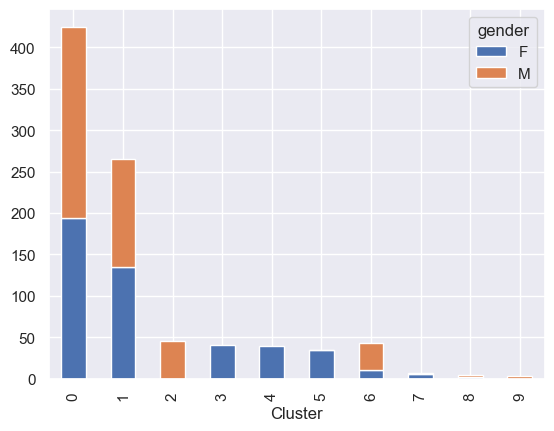

In [44]:
# Plots for Categorical Data
df3 = df2.copy()
df3['gender'] = df3['gender'].apply(lambda x: 'F' if x==0 else 'M').astype('str')

df3.groupby(['Cluster', 'gender']).size().unstack().plot(kind='bar', stacked=True)

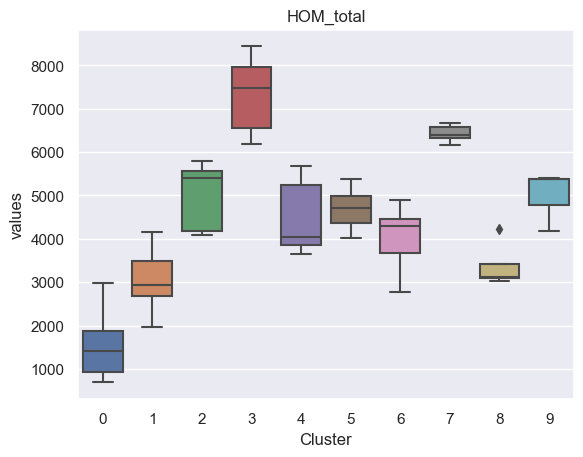

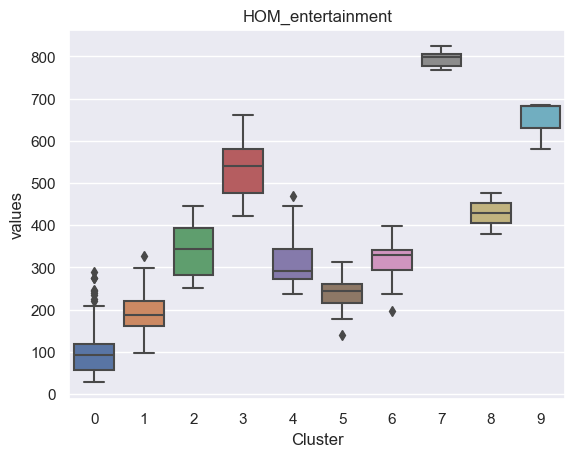

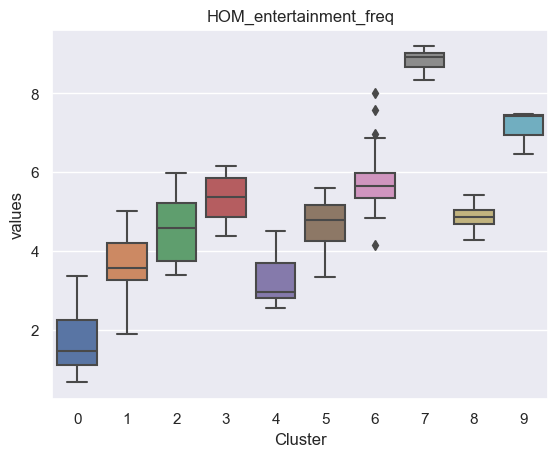

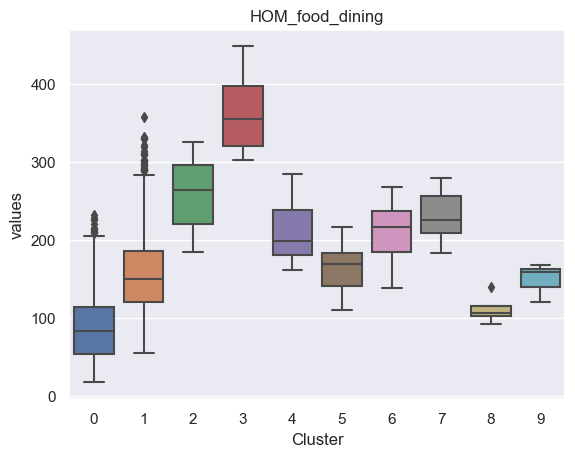

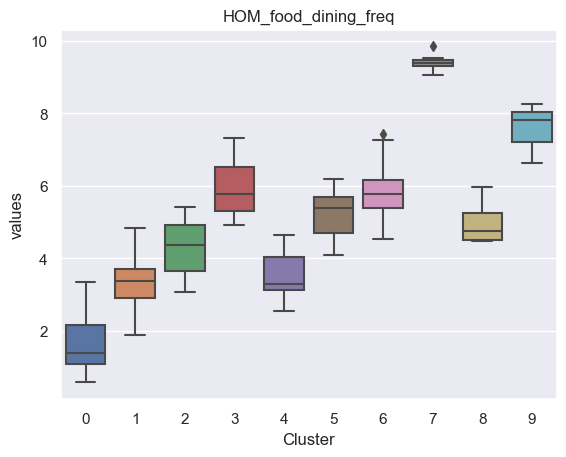

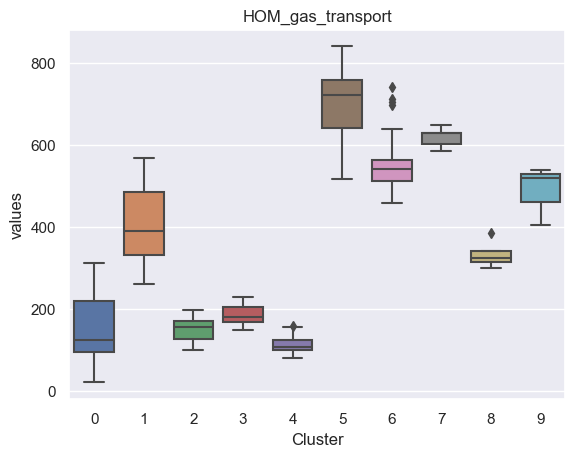

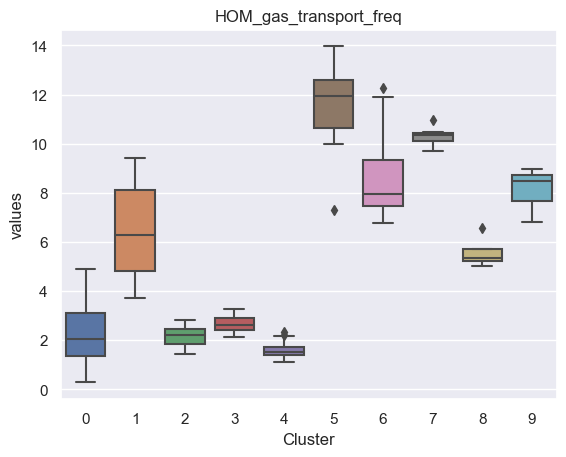

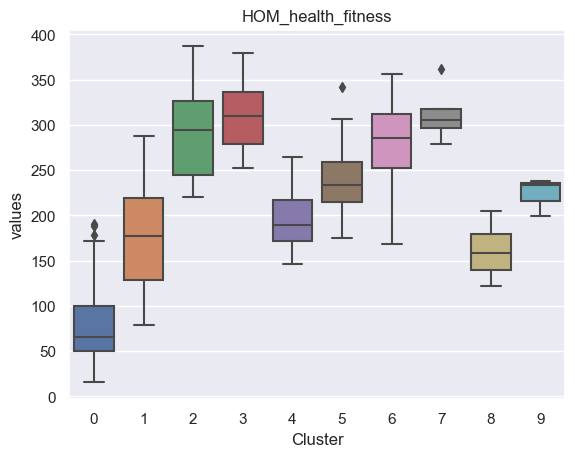

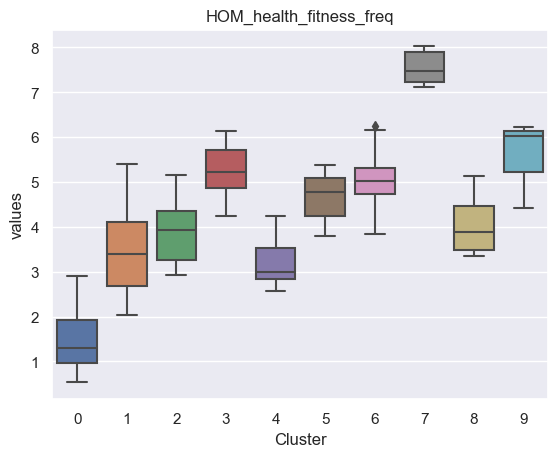

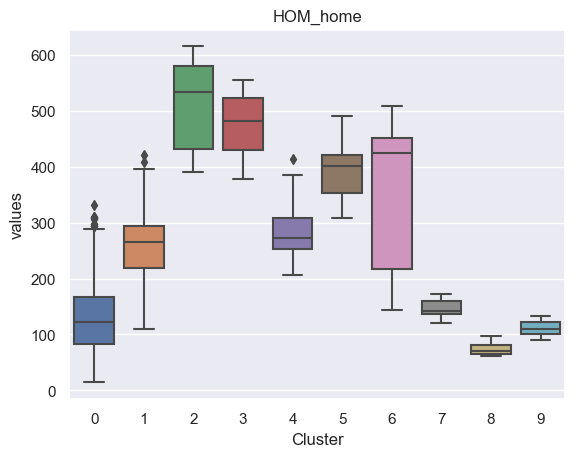

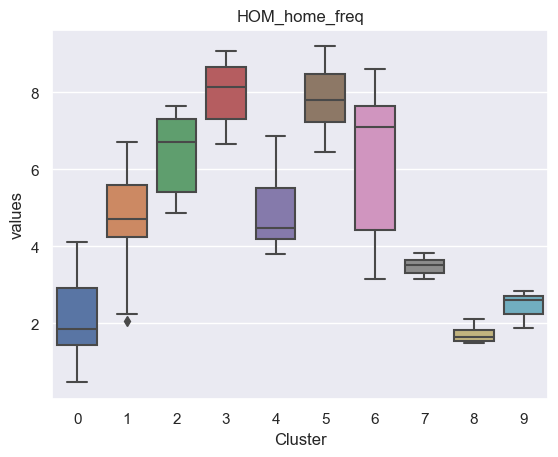

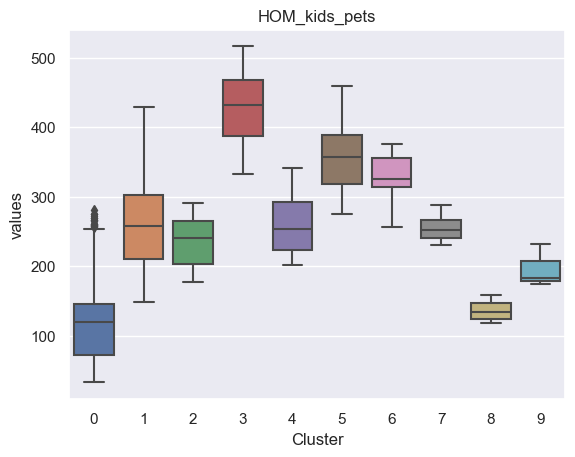

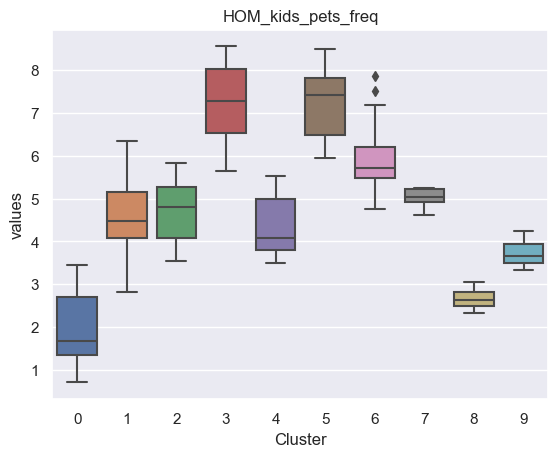

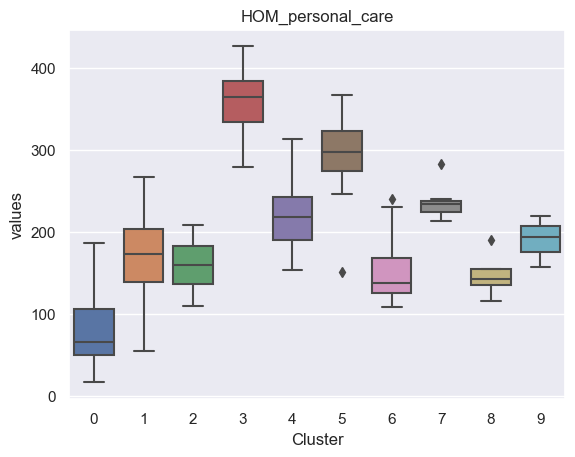

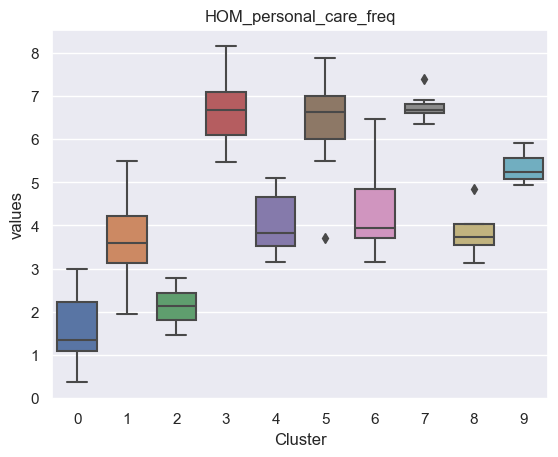

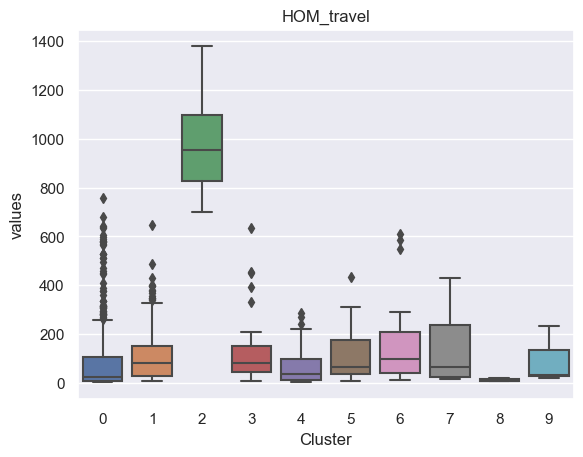

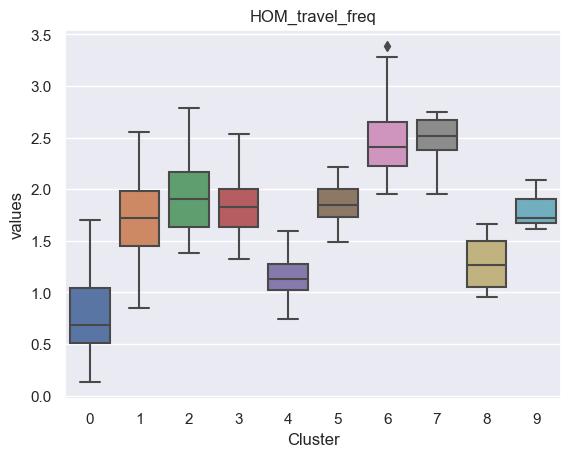

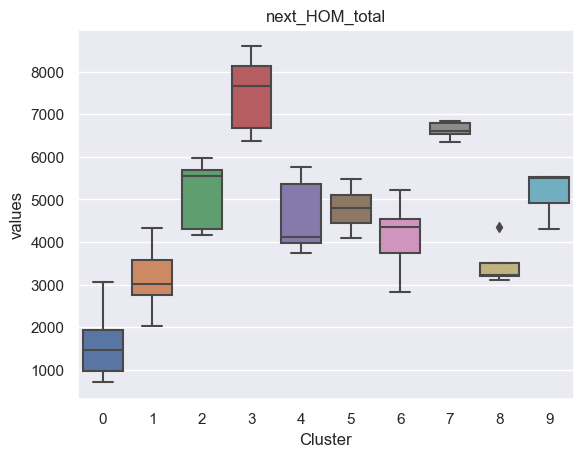

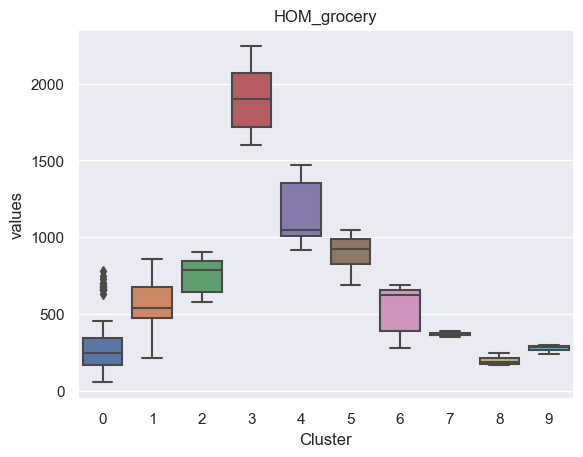

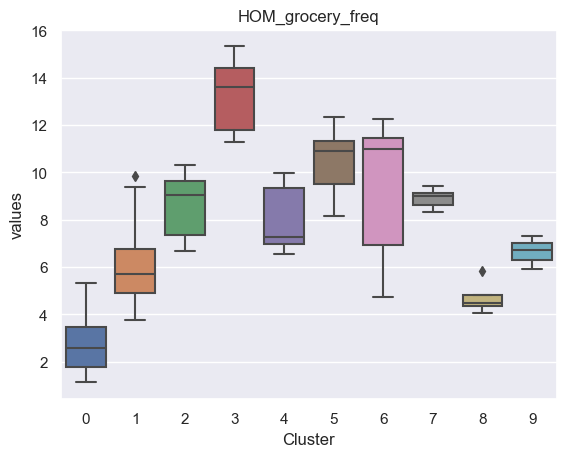

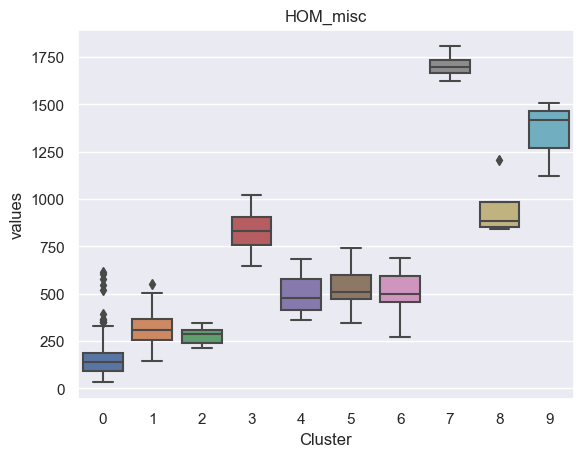

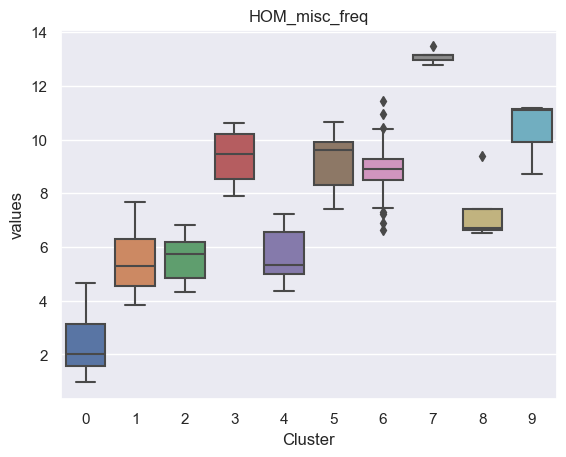

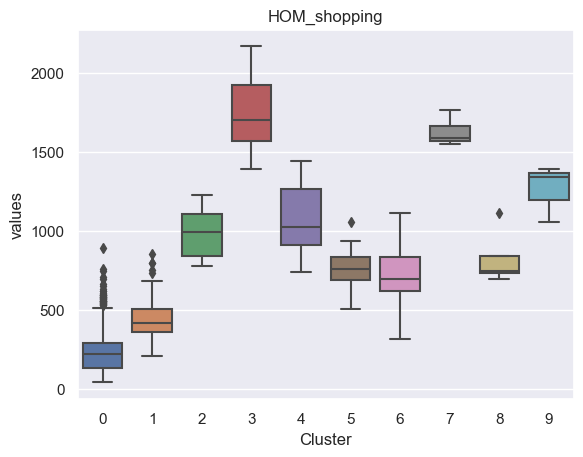

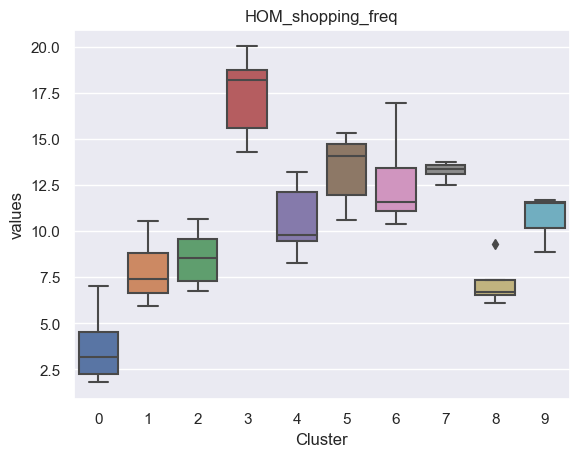

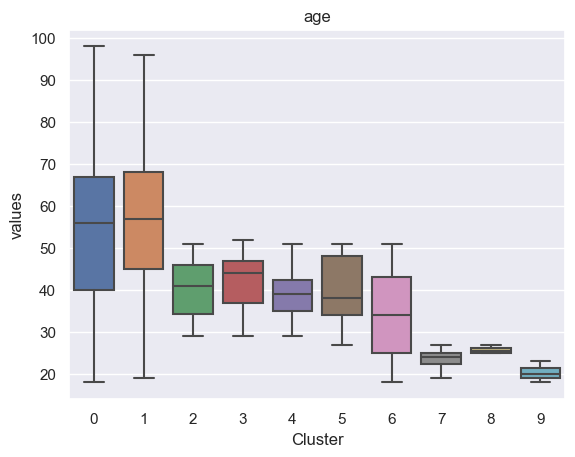

In [45]:
# Plots for Numerical Data
df_long = df2.melt(id_vars='Cluster', value_vars=df2.columns[:-1], var_name='variable', value_name='values')

for i in df2.columns:
    if i == 'gender' or i == 'Cluster':
        continue
    sns.boxplot(data=df_long[df_long['variable']==i], x='Cluster', y='values')
    plt.title(i)
    plt.show()